# Konecta Internship Task 5 (Image Classification using Deep Learning)

**Name:** Ahmed Ayman Ahmed Alhofy  
**Track:** Artificial Intelligence & Machine Learning  
**Repository Link:** [https://github.com/AhmedAyman4/konecta-internship/tree/main/Task-5](https://github.com/AhmedAyman4/konecta-internship/tree/main/Task-5)

### **Load Image Data and Explore it**

In [2]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.keras import TqdmCallback

# Scikit-learn (for evaluation metrics)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Optional (for reproducibility)
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sports-classification


In [5]:
# Path from the KaggleHub log
base_dir = "/kaggle/input/sports-classification"

# Subdirectories
train_dir = f"{base_dir}/train"
val_dir   = f"{base_dir}/valid"
test_dir  = f"{base_dir}/test"

# Parameters
img_height, img_width = 224, 224   # dataset images are 224x224
batch_size = 16

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Class names
class_names = train_ds.class_names
print("Number of classes:", len(class_names))
print("Example classes:", class_names[:10])

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Number of classes: 100
Example classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']


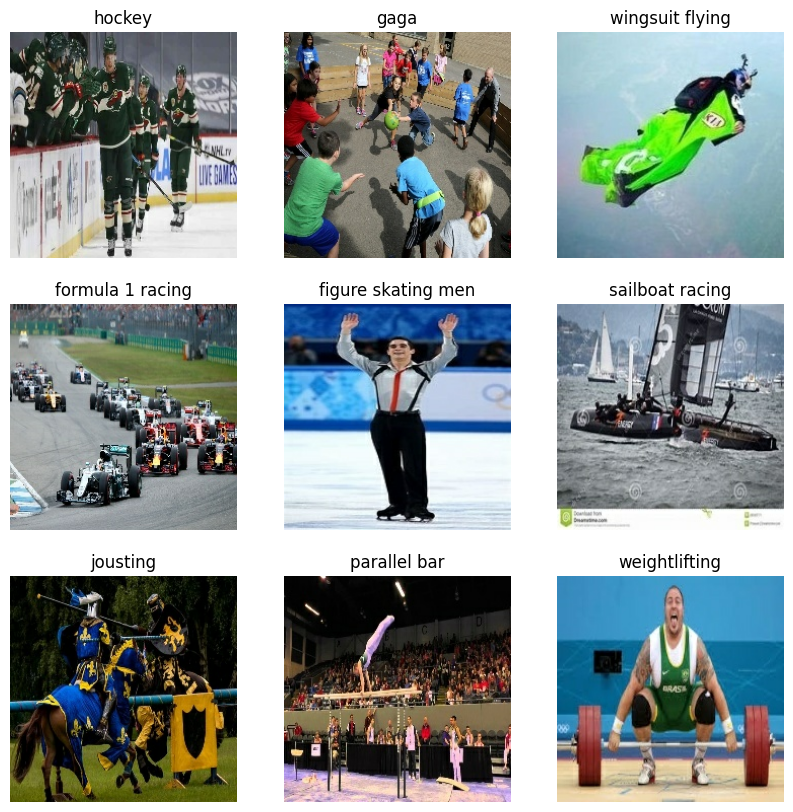

In [6]:
# Preview some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   # take 1 batch
    for i in range(9):   # show first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # convert tensor -> numpy -> image
        plt.title(class_names[labels[i]])  # show class name
        plt.axis("off")


### **Preprocessing & Performance**

**Normalize images and enable prefetching for faster training:**

* `AUTOTUNE` lets TensorFlow **automatically tune the performance** of your input pipeline (e.g., how many elements to fetch in parallel).
* It makes the pipeline faster without you needing to manually set parameters.
* `.cache()` Saves the dataset in memory **after the first load**, so it doesn’t repeatedly read from disk (faster training).
* `.prefetch(AUTOTUNE)`

   * While the model is training on one batch, TensorFlow **loads the next batch in the background**.
   * This overlaps data preparation with model execution, making training faster.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (x/255.0, y)).cache("train_cache").shuffle(100).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (x/255.0, y)).cache("val_cache").prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (x/255.0, y)).cache("test_cache").prefetch(AUTOTUNE)

### Model Training: MobileNetV2 for 100-Class Sports Image Classification

In this section, we train the **MobileNetV2** base model for the 100-class sports image classification task. The model is fine-tuned using transfer learning with the following configuration:

- **Number of Classes:** 100
- **Loss Function:** `sparse_categorical_crossentropy` (suitable for integer-labeled multi-class classification)
- **Optimizer:** Adam with initial learning rate of 0.01
- **Callbacks:**
  - `EarlyStopping`: Monitors validation accuracy, stops training if no improvement for 5 epochs, and restores the best weights.
  - `ReduceLROnPlateau`: Reduces learning rate by a factor of 0.2 if validation loss does not improve for 2 epochs.
  - `TqdmCallback`: Provides a progress bar for training visualization.

The model is trained for up to **10 epochs**, with validation performance monitored at each epoch. Training may terminate early based on validation accuracy trends to prevent overfitting.

In [8]:
def build_mobilenet(num_classes):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [10]:
num_classes = 100

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # watch validation accuracy
    mode='max',               # higher is better
    patience=5,               # wait 5 epochs before stopping
    restore_best_weights=True # keep the best model
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # watch validation loss
    factor=0.2,          # shrink learning rate to 20% of current
    patience=2,          # wait 2 bad epochs before reducing
    verbose=1
)


# MobileNetV2
mobilenet_model = build_mobilenet(num_classes)
mobilenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),  # safer option would be the default 0.001
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training MobileNetV2...")
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=16,
    epochs=50,  # higher max epochs, early stopping will stop earlier
    verbose=1,  # → one line per epoch (progress bar).
    callbacks=[TqdmCallback(verbose=1), early_stopping, reduce_lr]
)


Training MobileNetV2...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5078 - loss: 3.6728 - val_accuracy: 0.7340 - val_loss: 2.1341 - learning_rate: 0.0100
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7848 - loss: 1.8975 - val_accuracy: 0.8200 - val_loss: 1.4953 - learning_rate: 0.0100
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8297 - loss: 1.5249 - val_accuracy: 0.8460 - val_loss: 1.4724 - learning_rate: 0.0100
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8575 - loss: 1.4232 - val_accuracy: 0.8600 - val_loss: 1.5035 - learning_rate: 0.0100
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8702 - loss: 1.2703 - val_accuracy: 0.8840 - val_loss: 1.1737 - learning_rate: 0.0100
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8912 - loss: 1.0698 - val_accuracy: 0.8660 - val_loss: 1.5593 - learning_rate: 0.0100
Epoch 7/50
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8970 - lo

### Model Evaluation

Evaluate the trained model using:
- **Accuracy**
- **Precision, Recall, F1-score** (per-class, macro & micro averages)

**Plots to include:**
- Training vs. Validation Accuracy over epochs  
- Training vs. Validation Loss over epochs

In [11]:
print("\nEvaluating model...")
val_loss, val_acc = mobilenet_model.evaluate(val_ds, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")

# Collect true and predicted labels
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = mobilenet_model.predict(images)
    y_true.extend(labels.numpy())   # true labels are already integer class indices
    y_pred.extend(np.argmax(preds, axis=1))            # predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Evaluating model...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9355 - loss: 0.4913
Validation Accuracy: 0.9140
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━

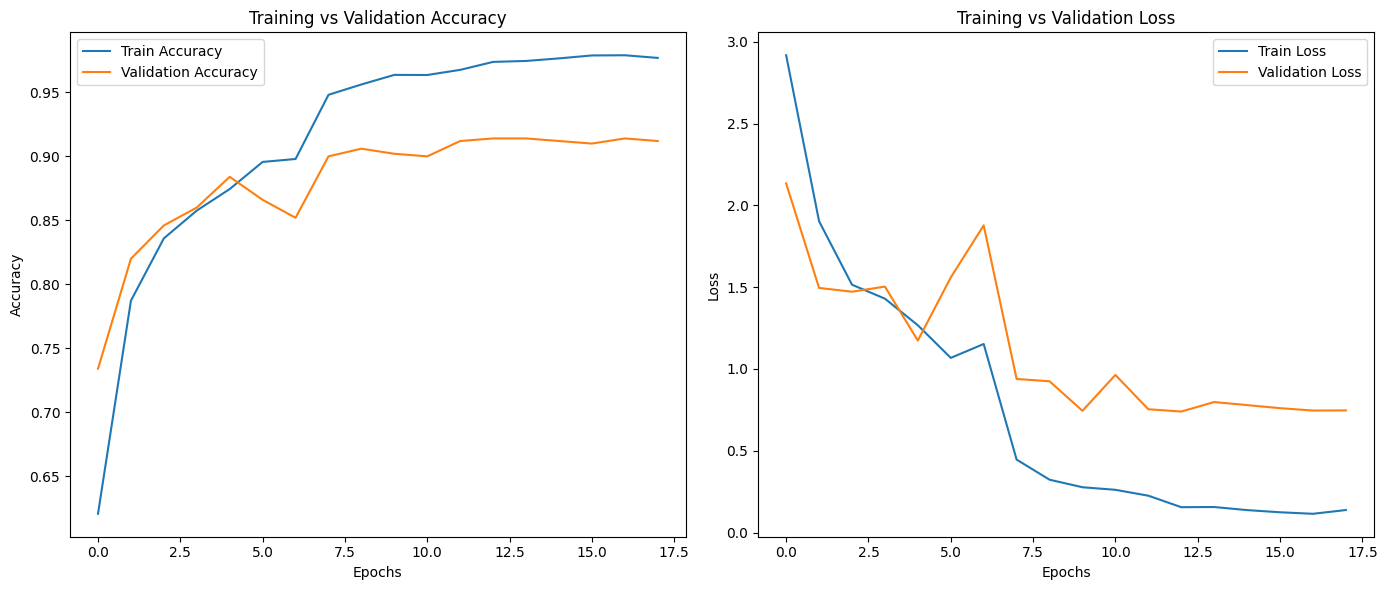

In [12]:
# Training Curves (Side by Side)
# ------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy subplot
ax1.plot(history_mobilenet.history["accuracy"], label="Train Accuracy")
ax1.plot(history_mobilenet.history["val_accuracy"], label="Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training vs Validation Accuracy")
ax1.legend()

# Loss subplot
ax2.plot(history_mobilenet.history["loss"], label="Train Loss")
ax2.plot(history_mobilenet.history["val_loss"], label="Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training vs Validation Loss")
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
# --- Evaluate on validation/test ---
val_loss, val_acc = mobilenet_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = mobilenet_model.evaluate(test_ds, verbose=0)

print("\n✅ Best Model Performance:")
print(f"Best Validation Accuracy: {val_acc:.4f}")
print(f"Best Validation Loss: {val_loss:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")


✅ Best Model Performance:
Best Validation Accuracy: 0.9140
Best Validation Loss: 0.7397
Final Test Accuracy: 0.9420
Final Test Loss: 0.6490


### Sample Predictions on Test Data

Visualize 16 test images with model predictions vs. true labels:
- Green title: Correct prediction
- Red title: Incorrect prediction

Uses batch from `test_ds` and converts class indices to names using `class_names`.  
Prediction is done via `mobilenet_model.predict()`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


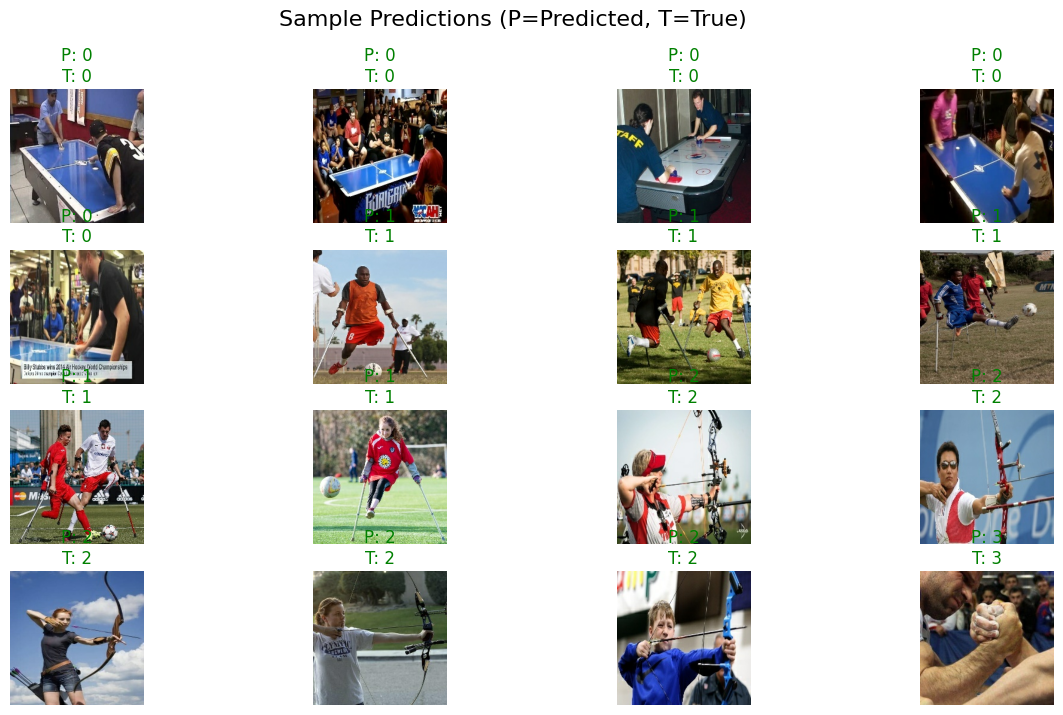

In [14]:
# Get one batch of test data
images, labels = next(iter(test_ds.unbatch().batch(16)))  # 16 sample images

# Run predictions
pred_probs = mobilenet_model.predict(images)
pred_classes = np.argmax(pred_probs, axis=1)

# Plot results
plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

    true_label = labels[i].numpy()
    pred_label = pred_classes[i]

    # Show predicted and true labels
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)

plt.suptitle("Sample Predictions (P=Predicted, T=True)", fontsize=16)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


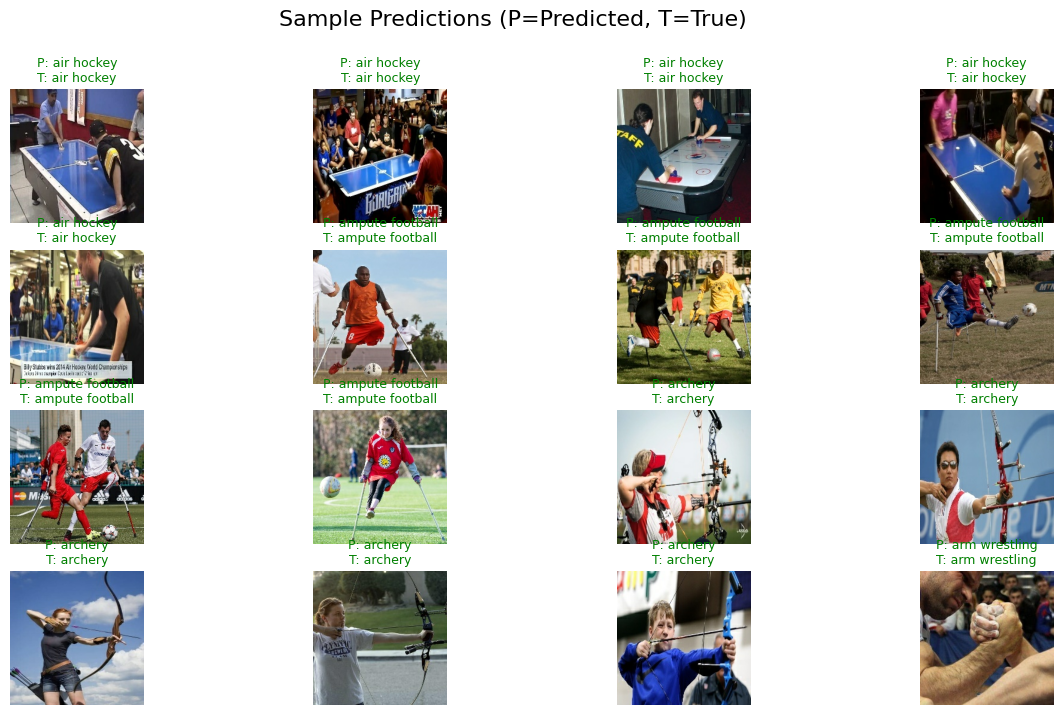

In [15]:
# Get class names from dataset
# class_names = train_ds.class_names # This line caused the error, using the existing class_names variable instead

# Take a batch of 16 test images
images, labels = next(iter(test_ds.unbatch().batch(16)))

# Get predictions
pred_probs = mobilenet_model.predict(images)
pred_classes = np.argmax(pred_probs, axis=1)

# Plot images with predicted vs true labels
plt.figure(figsize=(15, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis("off")

    true_label = labels[i].numpy()
    pred_label = pred_classes[i]

    # Convert class index → class name
    true_name = class_names[true_label]
    pred_name = class_names[pred_label]

    # Show result
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_name}\nT: {true_name}", color=color, fontsize=9)

plt.suptitle("Sample Predictions (P=Predicted, T=True)", fontsize=16)
plt.show()

In [16]:
# --- Save the best model in .keras format ---
mobilenet_model.save("mobilenet_best.keras")
print("\n💾 Model saved as 'mobilenet_best.keras'")



💾 Model saved as 'mobilenet_best.keras'
